In [1]:
import gentrl
import torch
import pickle
import pandas as pd
import numpy as np
from rdkit.Chem import Draw
from moses.metrics import mol_passes_filters, QED, SA, logP
from moses.metrics.utils import get_n_rings, get_mol
import matplotlib.pyplot as plt
import random
from utilities.config import Config

torch.cuda.set_device(0)

In [2]:
enc = gentrl.RNNEncoder(latent_size=50)
dec = gentrl.DilConvDecoder(latent_input_size=50)
model = gentrl.GENTRL(enc, dec, 50 * [('c', 20)], [('c', 20)], beta=0.001)
model.cuda();

model.load('saved_gentrl_LA_after_rl/')
model.cuda();

In [3]:
config = Config(smiles_format=2, topn_fp_features=5, mode='threshold', max_fp_features=2048, threshold=0.3, morgan_radius=2)
with open(config.FpsSOM_model, 'rb') as infile:
    fps_som = pickle.load(infile)

In [4]:
def sample_from_model(num_samples, model, contain_noise=False, ratio=0.3):
    if not contain_noise:
        z = model.lp.sample(num_samples, 50 * ['s'] + ['m'])
        smiles = model.dec.sample(50, z, argmax=False)
    else:
        exploit_size = int(num_samples*(1 - ratio))
        exploit_z = model.lp.sample(exploit_size, 50 * ['s'] + ['m'])
        z_means = exploit_z.mean(dim=0)
        z_stds = exploit_z.std(dim=0)
        
        expl_size = int(num_samples * ratio)
        expl_z = torch.randn(expl_size, exploit_z.shape[1]).to(exploit_z.device)
        z = torch.cat([exploit_z, expl_z])
        smiles = model.dec.sample(50, z, argmax=False)
        
    return smiles
        

In [ ]:
exist_smiles = set()


In [5]:
generated = set()

while len(generated) < 200:
    sampled = sample_from_model(50, model, False)
    sampled_valid = [s for s in sampled if get_mol(s)]
    
    generated.update(sampled_valid)

RDKit ERROR: [19:34:05] SMILES Parse Error: extra open parentheses for input: 'NCC(COc1ccc(Cl)cc1NCC(F)F'
RDKit ERROR: [19:34:05] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9
RDKit ERROR: 
RDKit ERROR: [19:34:05] SMILES Parse Error: unclosed ring for input: 'COCC(=O)Nc1ccc(Cl)cc1NC(C)c1c'
RDKit ERROR: [19:34:07] SMILES Parse Error: extra close parentheses while parsing: COCC(=O)Nc1ccc(Cl)cc1NCC(F)F)cc1
RDKit ERROR: [19:34:07] SMILES Parse Error: Failed parsing SMILES 'COCC(=O)Nc1ccc(Cl)cc1NCC(F)F)cc1' for input: 'COCC(=O)Nc1ccc(Cl)cc1NCC(F)F)cc1'
RDKit ERROR: [19:34:09] SMILES Parse Error: extra open parentheses for input: 'FC(F)NC(Cc1ccccc1NCC(C)C'
RDKit ERROR: [19:34:12] SMILES Parse Error: extra open parentheses for input: 'COCCc1csc(NC(=O)c2cccc(Cl)c1N'
RDKit ERROR: [19:34:13] SMILES Parse Error: unclosed ring for input: 'CN(C)c1cc(C(=O)NCc2cccs2)c1OCC1'
RDKit ERROR: [19:34:14] SMILES Parse Error: extra open parentheses for input: 'NCC(C)c1cccc(NC(=O)CC1CC1'
RDKit ERROR: [19:3

In [6]:
# Draw.MolsToGridImage([get_mol(s) for s in sampled_valid], 
#                      legends=[str(fps_som.som_reward(s)) for s in sampled_valid])

In [7]:
gen_smiles = list(generated)
grades = [fps_som.som_reward(s) for s in gen_smiles]
idxs = np.argsort(grades).tolist()
idxs = idxs[::-1]
    
smiles_list = [gen_smiles[i] for i in idxs]
grades_list = [grades[i] for i in idxs]

In [ ]:
for s,g in zip(smiles_list, grades_list):
    print(s, g)

In [9]:
# img=Draw.MolsToGridImage([get_mol(sm) for sm in smiles_list[:70]],molsPerRow=4,subImgSize=(200,200),legends=[str(fps_som.som_reward(s)) for s in smiles_list], returnPNG=False)

In [10]:
# img.save('images/candidate_210520.png')

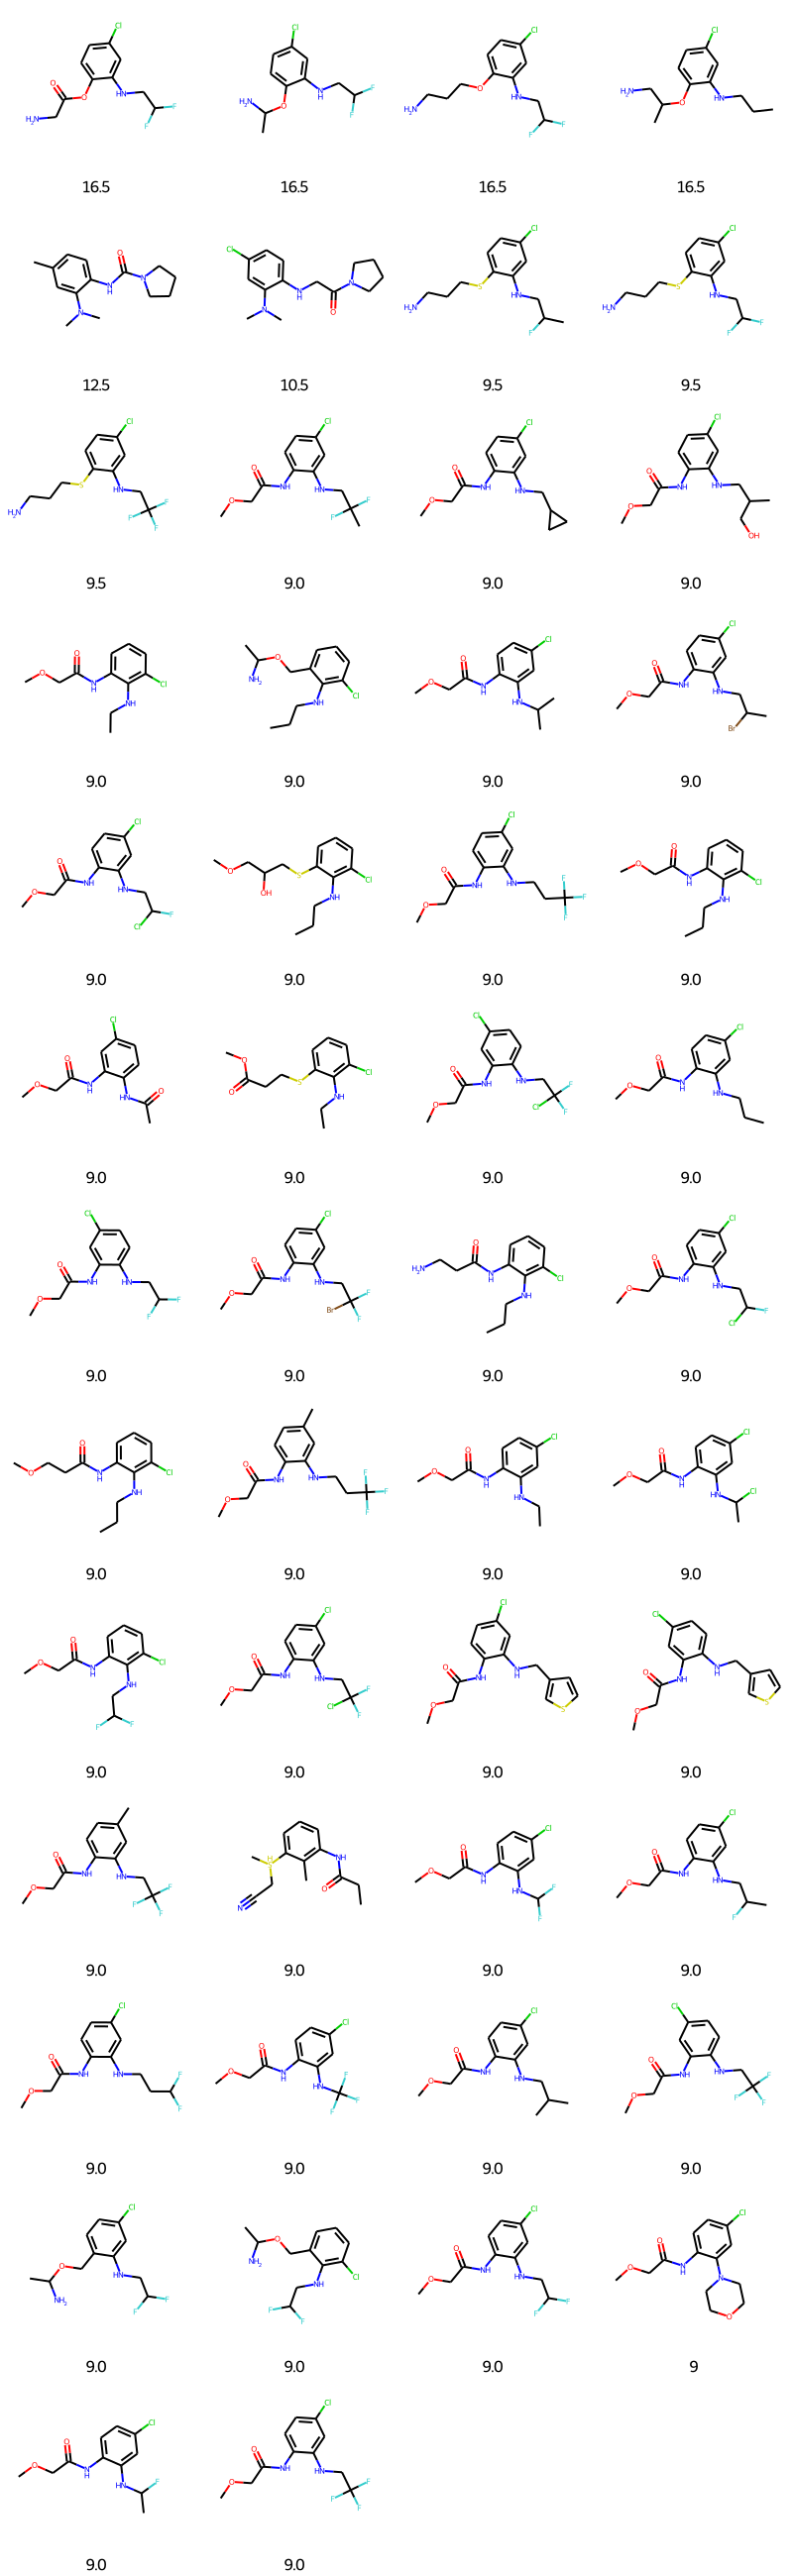

In [12]:
Draw.MolsToGridImage([get_mol(sm) for sm in smiles_list],molsPerRow=4,subImgSize=(200,200),legends=[str(fps_som.som_reward(s)) for s in smiles_list], returnPNG=False)

# generated results falls into some pattern, lost the innovativity